# Supervised learning- categorisation- logistic regression

# 0. Loading packages and dataset

In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('real_estate_cleaned.csv')

We will use the same dataset as for the regression setting. But now, we will not try to predict the price, but the price class. In the following code, I create two price classes
+ 0 = all prices below 400 000 (or the log(prices) < 12.9 - remember that we used the log-transform when cleaning the data)
+ 1 = all prices above 400 000


In [53]:
#df['price_class'] = 1
#df['price_class'][df.tx_price > 12.9] = 2
#df['price_class'][df.tx_price > 13.3] = 3

df['price_class'] = 0
df.loc[df.tx_price > 12.9, 'price_class'] = 1
#df['price_class'][df.tx_price > 12.9] = 1


In [54]:
df[['price_class','tx_price']]

,price_class,tx_price
0,0,12.597611
1,0,12.285350
2,0,12.542191
3,0,12.847666
4,0,12.736704
...,...,...
798,1,13.523231
799,1,13.253393
800,1,12.921473
801,1,12.955130


Let's see how many observations we have in each class

In [55]:
df['price_class'].value_counts()

price_class
0    566
1    237
Name: count, dtype: int64

Clearly imbalanced. We will see how to deal with this later on.

In [56]:
df_new = df.drop(columns='tx_price')

In [57]:
df_new.head()

,beds,baths,sqft,year_built,lot_size,restaurants,groceries,nightlife,cafes,shopping,...,exterior_walls_Wood,roof_Asphalt,roof_Composition,roof_Gravel/rock,roof_Missing,roof_Other,roof_Shake shingle,basement_1.0,basement_Missing,price_class
0,1,1,6.371612,2013,8.388054,4.682131,2.302585,3.433987,2.995732,4.499810,...,1,0,0,0,1,0,0,0,1,0
1,1,1,6.418365,1965,8.388054,4.663439,2.772589,1.945910,2.639057,4.477337,...,0,0,1,0,0,0,0,1,0,0
2,1,1,6.423247,1963,8.388054,5.214936,2.639057,3.465736,3.433987,4.624973,...,1,0,0,0,1,0,0,0,1,0
3,1,1,6.428105,2000,10.420554,5.293305,2.302585,3.663562,3.258097,4.852030,...,1,0,0,0,1,0,0,0,1,0
4,1,1,6.453625,1992,8.388054,5.010635,2.079442,3.135494,3.044522,4.430817,...,0,0,0,0,1,0,0,0,1,0


Note that we only did this for instruction reasons. You do not want to classify your outcome like this if you have continuous data. An algoritm will always be able to get more information out of the continuous data. Say you are only interested in knowing if a house is more expensive than 500 000 euro or not. Then it is a better strategy to predict the continuous prices and then classify after prediction). 

## 0.1. Train/val/test-split
We make a three-way split, because we need an extra hold-out set for the calibration.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df_new.drop(columns='price_class')
y = df_new['price_class']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=81357)


num_feat = ['beds', 'baths', 'sqft', 'year_built', 'lot_size', 'restaurants',
       'groceries', 'nightlife', 'cafes', 'shopping', 'arts_entertainment',
       'beauty_spas', 'active_life', 'median_age', 'married', 'college_grad',
       'property_tax', 'insurance', 'median_school', 'num_schools', 'tx_year',
       'school_score', 'tax_per_sqft']
scaler = StandardScaler()
X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()

X_test_stand = X_test.copy()
X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])
X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

In [59]:
X_train.head()

,beds,baths,sqft,year_built,lot_size,restaurants,groceries,nightlife,cafes,shopping,...,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition,roof_Gravel/rock,roof_Missing,roof_Other,roof_Shake shingle,basement_1.0,basement_Missing
531,3,3,7.107425,1987,7.727535,3.688879,2.079442,1.386294,1.098612,3.367296,...,0,0,0,1,0,0,0,0,1,0
618,3,3,7.484930,1968,7.602900,4.262680,1.098612,2.079442,2.302585,4.394449,...,0,1,0,1,0,0,0,0,1,0
260,2,2,7.147559,1996,8.388054,3.433987,1.386294,1.386294,0.693147,2.890372,...,0,0,0,1,0,0,0,0,1,0
669,3,3,7.773594,1983,7.813996,2.639057,0.693147,0.000000,0.000000,1.945910,...,0,0,0,1,0,0,0,0,1,0
440,3,2,7.428333,2004,7.500529,0.000000,0.000000,0.000000,0.000000,1.945910,...,1,0,0,0,0,1,0,0,1,0


# 1. Logistic regression
 ## 1.1 Basic model

We start with the simple logistic regression model. The C-parameter (the inverse of the regularisation) is per default at 1, which means there is regularisation. To have no regularisation, we put C at a very high number (10 000). Since we have a validation set, we can evaluate on that one, whitout risking bias

In [60]:
from sklearn.linear_model import LogisticRegression

# Fit the model
logreg = LogisticRegression(C=10000, max_iter=200) 
logreg.fit(X_train_stand, y_train)

# then do the calibration (cv='prefit')
print(logreg.score(X_train_stand, y_train))
print(logreg.score(X_val_stand, y_val))


0.8791423001949318
0.7751937984496124


The score object gives the accuracy for classification (while it gives the R2 for regression problems). The predictions can also be asked as before. You can choose between .predict(), which gives the predicted class and .predict_proba(), which gives the predicted chance for each class.

In [61]:
y_val_pred = logreg.predict(X_val_stand)

In [62]:
y_val_pred_prob = logreg.predict_proba(X_val_stand)

We can also take a look at the confusion matrix.

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix)



[[77 12]
 [17 23]]


You could now calculate the quality measure you want yourself. Or you can get some specific quality metrics from a classification report.


In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        89
           1       0.66      0.57      0.61        40

    accuracy                           0.78       129
   macro avg       0.74      0.72      0.73       129
weighted avg       0.77      0.78      0.77       129



+ we get the accuracy.
+ The macro average is the average over the two classes for each specific measure
+ The weighted average is the same as the macro average, but weighted for the number of observations in each class.

Notice the high recall for the first class, while the recall of the second class is very low. This might be because of the imbalanced nature of our dataset. There are a lot of observations in class 1. We should take this into account (but we will see how in the next class). We will first focus on calibration.


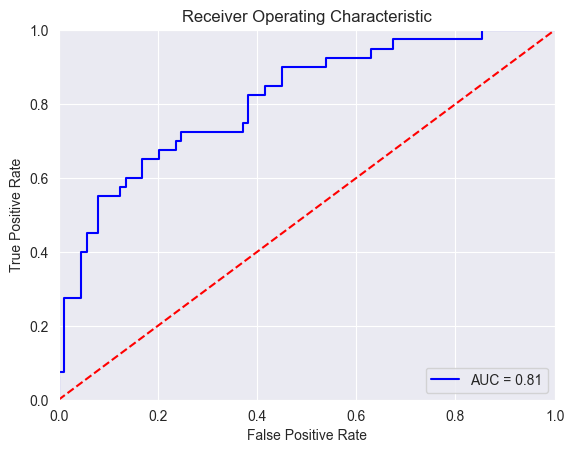

In [65]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = y_val_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 1.2 Calibration

Let's check if our model is wel calibrated, and if not, perform a calibration.

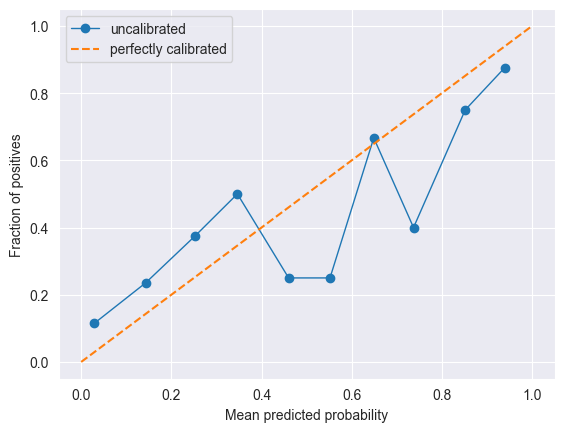

In [66]:
from sklearn.calibration import calibration_curve
y_pred_val_prob = logreg.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

This is not good, but not teribly bad either (normally, logistic model tend to be well calibrated, calibration is more needed for tree-based methods, support vector machines...). We will do a isotonic regression to correct this. Note that we use the validationset to fit the isotonic regression. We set cv at 'prefit', because we have already fitted the model. So, the function assumes it can use the entire input dataset for validation.

In [67]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
isotonic = CalibratedClassifierCV(logreg, cv='prefit', method='isotonic')
isotonic.fit(X_val_stand, y_val)

C:\Users\teode\IdeaProjects\AppliedArtificialIntelligence\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=10000, max_iter=200),
                       method='isotonic')

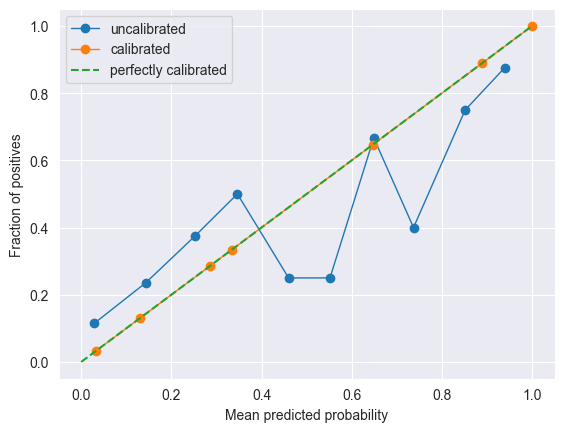

In [68]:
from sklearn.calibration import calibration_curve

y_val_pred_prob_c = isotonic.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')

plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')

plt.legend()
plt.show()

Now, this is much better (do not expect you calibration to end up to be perfect like this, especially not for other algorithms.)

In [69]:
y_pred = logreg.predict(X_val_stand)
y_pred_c = isotonic.predict(X_val_stand)

print(classification_report(y_val, y_pred))
print(classification_report(y_val, y_pred_c))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        89
           1       0.66      0.57      0.61        40

    accuracy                           0.78       129
   macro avg       0.74      0.72      0.73       129
weighted avg       0.77      0.78      0.77       129

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        89
           1       0.76      0.55      0.64        40

    accuracy                           0.81       129
   macro avg       0.79      0.74      0.75       129
weighted avg       0.80      0.81      0.80       129



We see a good recal for the first class, but a drop for the second class. You actually don't have to do the fitting of the model and the calibration seperately. You can do this at once (and it is better), using the CalibratedClassifierCV, but now you give a value for CV (e.g 3 or 5) instead of 'prefit'. A cross-validation is performed, where the train-set is split into 2, one for training and one for calibration. Since we want to compare several algorithms, we keep the validation dataset seperate to evaluate on (if you choose one algorithm, you can use the complete train_val dataset to do training and calibration on). 

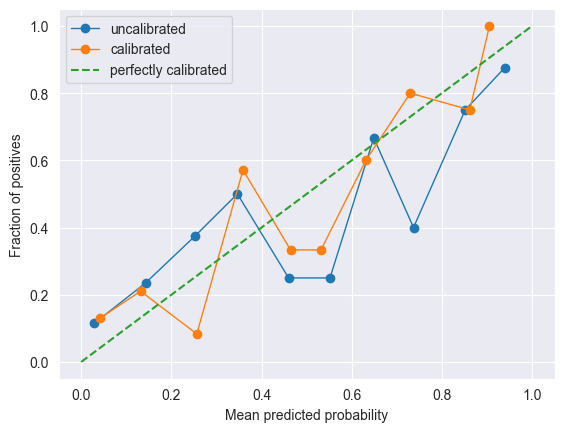

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        89
           1       0.76      0.55      0.64        40

    accuracy                           0.81       129
   macro avg       0.79      0.74      0.75       129
weighted avg       0.80      0.81      0.80       129

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        89
           1       0.68      0.57      0.62        40

    accuracy                           0.78       129
   macro avg       0.75      0.73      0.73       129
weighted avg       0.78      0.78      0.78       129



In [70]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
logreg2 = LogisticRegression(C=10000, max_iter=1000) 
isotonic2 = CalibratedClassifierCV(logreg2, cv=3, method='isotonic')
isotonic2.fit(X_train_stand, y_train)


# The calibration plot
y_val_pred_prob_c2 = isotonic2.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c2[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')

plt.legend()
plt.show()

y_pred_c2 = isotonic2.predict(X_val_stand)
print(classification_report(y_val, y_pred_c))
print(classification_report(y_val, y_pred_c2))

While this calibration seems less good in the plot, it is a much more realistic picture. It isn't perfect on the line, because there have been 3 seperate calibrations, one for each test-fold within the cross-validation, resulting in three models. At the end, the predicted chance is the average of the three models. This is an example of ensemble learning.



## 1.3 Imbalanced data
The dataset is imbalanced: there are a lot of observations in class 1.We should take this into account. We could use over- or undersampling. But logistic regression has a built-in argument to do class-weight balancing. (more about this in class 6) So, we will use that.

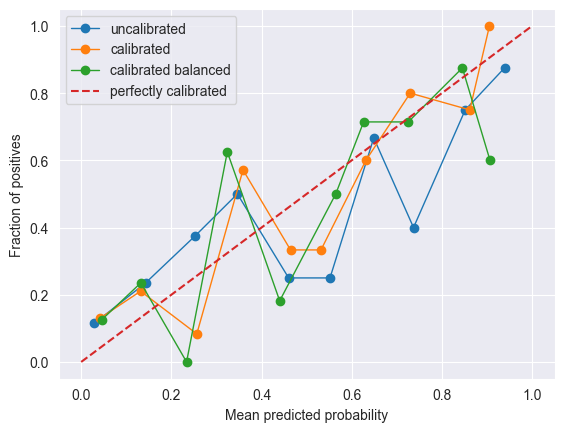

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        89
           1       0.68      0.57      0.62        40

    accuracy                           0.78       129
   macro avg       0.75      0.73      0.73       129
weighted avg       0.78      0.78      0.78       129

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        89
           1       0.71      0.55      0.62        40

    accuracy                           0.79       129
   macro avg       0.76      0.72      0.74       129
weighted avg       0.78      0.79      0.78       129



In [71]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
logreg_balanced = LogisticRegression(C=10000, class_weight='balanced', max_iter=1000) 
isotonic3 = CalibratedClassifierCV(logreg_balanced, cv=3, method='isotonic')
isotonic3.fit(X_train_stand, y_train)

# The calibration plot
y_val_pred_prob_c3 = isotonic3.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c2[:,1],n_bins=10)
fop_c3, mpv_c3 = calibration_curve(y_val,y_val_pred_prob_c3[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot(mpv_c3,fop_c3, marker='o', linewidth=1, label='calibrated balanced')

plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')

plt.legend()
plt.show()

y_pred_c3 = isotonic3.predict(X_val_stand)
print(classification_report(y_val, y_pred_c2))
print(classification_report(y_val, y_pred_c3))

We can see that the recall of the second class did not improve here.

## 1.4 Adding polynomials and penalisation

Let's add polynomials, but immediately do the penalisation as well (since sklearn does this automatically anyway, using l2). We will go up to the 3th order of polynomials and then regulate it back down using penalisation (you could go to a higher order, but I choose 3 to keep the computation time low for instruction reasons). If you have more time to run the model, try it out and see what happens if you increase the order.

We will also use cross-validation to find the optimal penalisation factor C. We will train on accuracy, since we don't really have a preference for recall or precision here. sklearn picks accuracy automatically, so you actually don't need to specify this, but just to show how to do this in case you want another metric, I show how.



In [72]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)
# other possibilities are metrics.recall_score, metrics.average_precision, ...

C = [round(x,5) for x in np.linspace(start = 0.0001, stop = 10, num = 1000)]
#penalty = ['l1', 'l2']
class_weight = ['balanced']
random_grid = {'C': C,    
               'class_weight': class_weight}

#Designing polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_stand)
X_val_poly = poly.fit_transform(X_val_stand)
X_test_poly = poly.transform(X_test_stand)

# The object to fit the model
logreg = LogisticRegression( max_iter=1000) 

# object for the randomised search
log_random = RandomizedSearchCV(estimator = logreg, param_distributions = random_grid,
                                scoring=prec_scorer, n_iter = 100,
                               cv = 3, verbose=2,  n_jobs=-1)

#Fitting model (model+ calibration)
log_random.fit(X_train_poly, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [22]:
log_random.best_score_

np.float64(0.8518518518518517)

In [23]:
log_random.best_params_

{'class_weight': 'balanced', 'C': np.float64(0.05015)}

C:\Users\teode\AppData\Local\Temp\ipykernel_17128\4204110423.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  out2['param_class_weight'].iloc[res] = "No"
C:\Users\teode\AppData\Local\Temp\ipykernel_17128\4204110423.py:5: SettingWithCopyWa

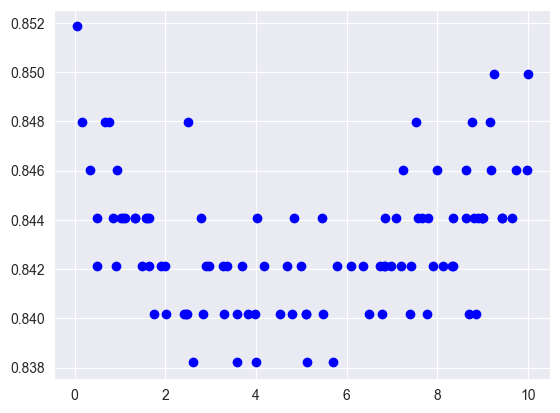

In [24]:
out2 = pd.DataFrame(log_random.cv_results_)

#Have to replace the None values with something else, or it wont make the plots
res = [i for i in range(len(out2['param_class_weight'])) if out2['param_class_weight'][i] == None] 
out2['param_class_weight'].iloc[res] = "No"

xlabel_names = ['param_C','param_class_weight']


plt.scatter(out2['param_C'], out2['mean_test_score'], c='blue');


We can see that lower values for C (high regularisation) lead to higher accuracy. We will zoom in on these values. But, we also include the calibration now.

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)
# other possibilities are metrics.recall_score, metrics.average_precision, ...

C = [round(x,5) for x in np.linspace(start = 0.01, stop =4, num = 100)]
class_weight = ['balanced']

random_grid = {'C': C,
               'class_weight': class_weight}

# The object to fit the model
logreg_balanced = LogisticRegression( max_iter=1000) 

# object for the randomised search
log_grid = GridSearchCV(estimator = logreg_balanced, param_grid = random_grid,
                                scoring=prec_scorer  , cv = 3, verbose=2,  n_jobs=-1)
isotonic_log = CalibratedClassifierCV(log_grid, cv=3, method='isotonic')

#Fitting model (model+ calibration)
isotonic_log.fit(X_train_poly, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=LogisticRegression(max_iter=1000),
                                              n_jobs=-1,
                                              param_grid={'C': [np.float64(0.01),
                                                                np.float64(0.0503),
                                                                np.float64(0.09061),
                                                                np.float64(0.13091),
                                                                np.float64(0.17121),
                                                                np.float64(0.21152),
                                                                np.float64(0.25182),
                                                                np.float64(0.29212),
                                                                np.float64(0.33242),
                                                                np.float64(0.37273),
                                                                np.float64(0.41303),
                                                                np.floa...
                                                                np.float64(0.73545),
                                                                np.float64(0.77576),
                                                                np.float64(0.81606),
                                                                np.float64(0.85636),
                                                                np.float64(0.89667),
                                                                np.float64(0.93697),
                                                                np.float64(0.97727),
                                                                np.float64(1.01758),
                                                                np.float64(1.05788),
                                                                np.float64(1.09818),
                                                                np.float64(1.13848),
                                                                np.float64(1.17879), ...],
                                                          'class_weight': ['balanced']},
                                              scoring=make_scorer(accuracy_score, response_method='predict'),
                                              verbose=2),
                       method='isotonic')

In [26]:
#isotonic_log.best_params_


This doesn't work, because we do not have 1 best model, but three, because of the cross-validation. So each fold choses its own best model and calibrates this.

In [27]:
isotonic_log.score(X_val_poly, y_val)

0.8682170542635659

In [28]:
y_pred_poly = isotonic_log.predict(X_val_poly)
print(classification_report(y_val, y_pred_poly))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        89
           1       1.00      0.57      0.73        40

    accuracy                           0.87       129
   macro avg       0.92      0.79      0.82       129
weighted avg       0.89      0.87      0.86       129



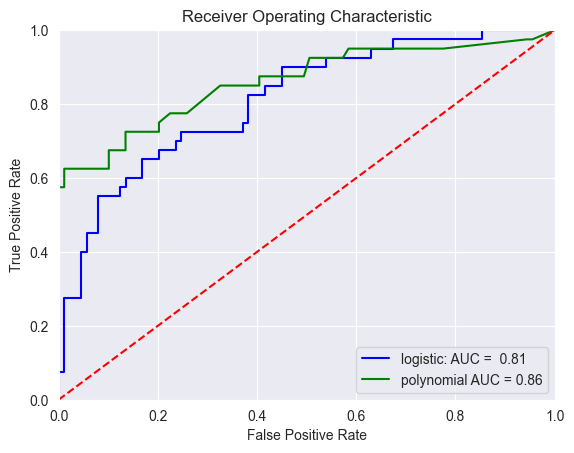

In [29]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = y_val_pred_prob[:,1]
preds_poly = isotonic_log.predict_proba(X_val_poly)[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC-curve shows that this final model is better than the simple logistic regression (which was already pretty good.)

# PART 2: Demo for the second class of categorisation

# 2. knn


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
n_neighbors = 4*np.arange(1,50)
param_grid = {'n_neighbors': n_neighbors}
knn = KNeighborsClassifier( )
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, scoring=prec_scorer ,cv = 5,  verbose=2, n_jobs = -1)
grid_search.fit(X_train_stand, y_train)
grid_search.best_params_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


{'n_neighbors': np.int64(12)}

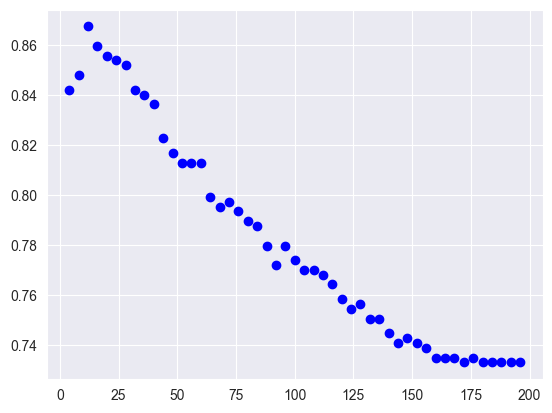

In [31]:
out2 = pd.DataFrame(grid_search.cv_results_)
xlabel_names = ['n_neighbors']
plt.scatter(out2['param_n_neighbors'], out2['mean_test_score'], c='blue');


In [32]:
y_pred_knn = grid_search.predict(X_val_stand)
print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        89
           1       0.84      0.53      0.65        40

    accuracy                           0.82       129
   macro avg       0.83      0.74      0.76       129
weighted avg       0.82      0.82      0.81       129



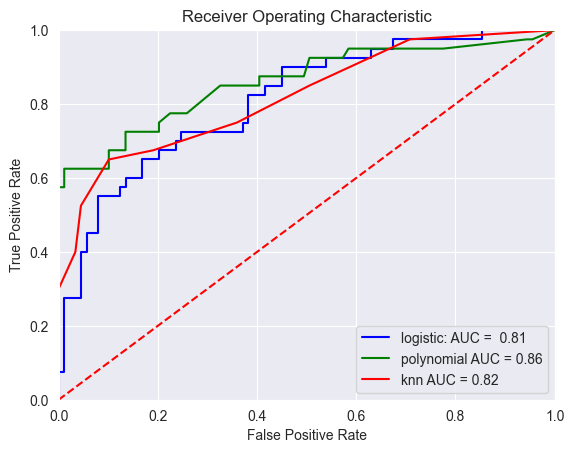

In [33]:
preds = y_val_pred_prob[:,1]
preds_poly = isotonic_log.predict_proba(X_val_poly)[:,1]
preds_knn = grid_search.predict_proba(X_val_stand)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Seems that the polynomial logistic model performed better. However, we did not correct for the imbalance in this model. There is no function class_weight for knn. So we will have to correct the imbalance ourself. We will use hybrid sampling, where we first oversample using smote and then also undersample.

In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.8, random_state=1703)
under = RandomUnderSampler(sampling_strategy=1)
pipeline = Pipeline([('o', over), ('u', under)])

X_train_smote, y_train_smote = pipeline.fit_resample(X_train_stand.copy(), y_train.copy())
X_val_smote, y_val_smote = pipeline.fit_resample(X_val_stand.copy(), y_val.copy())
np.bincount(y_val_smote)

C:\Users\teode\IdeaProjects\AppliedArtificialIntelligence\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\teode\IdeaProjects\AppliedArtificialIntelligence\venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\teode\IdeaProjects\AppliedArtificialIntelligence\venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\teode\IdeaProjects\AppliedArtificialIntelligence\venv\lib\site-packages\sklearn\base.py:474

array([71, 71])

we already know lower values of k perform better, so I will focus on the lower values (up to 50 instead of 200 previously)

In [35]:
n_neighbors = np.arange(1,50)
param_grid = {'n_neighbors': n_neighbors}

knn_b = KNeighborsClassifier( )
grid_search_knn = GridSearchCV(estimator = knn, param_grid = param_grid, scoring=prec_scorer ,cv = 5,  verbose=2, n_jobs = -1)
isotonic_knn = CalibratedClassifierCV(grid_search_knn, cv=3, method='isotonic')


isotonic_knn.fit(X_train_smote, y_train_smote)


Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=5,
                                              estimator=KNeighborsClassifier(),
                                              n_jobs=-1,
                                              param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                                              scoring=make_scorer(accuracy_score, response_method='predict'),
                                              verbose=2),
                       method='isotonic')

In [36]:
y_pred_knn_b = isotonic_knn.predict(X_val_stand)
print(classification_report(y_val, y_pred_knn_b))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        89
           1       0.71      0.55      0.62        40

    accuracy                           0.79       129
   macro avg       0.76      0.72      0.74       129
weighted avg       0.78      0.79      0.78       129



The two results for both recall and precision are now a lot better balanced between the two classes. And the overal accuracy is also higher.

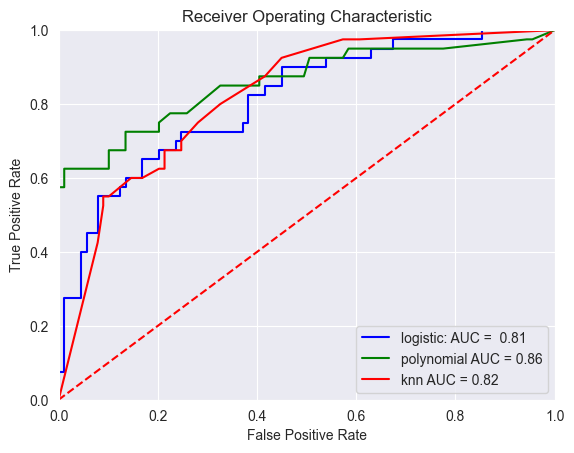

In [37]:
preds_knn_b = isotonic_knn.predict_proba(X_val_stand)[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn_b)


roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

But the polynomial model still performs better overal. And according to the ROC-curve the model became worse. You see, you need to decide in advance what you will use to evaluate your model, or you will have conflicting messages. Let's move on to tree-based models.

# 3. GBM
We won't do the simple decision tree or random forest, but just stick to the gradient boosting machine for the tree based methods. Again, it is very similar to the regression setting. Since GBM also does not have a class_weight function, we will use the smoted dataset again. 

We begin with a random search and end with a grid search that includes the calibration.

In [38]:
np.linspace(start = 0.001, stop = 1.5, num = 50)
#np.linspace(1, 10, num = 20)
    

array([1.00000000e-03, 3.15918367e-02, 6.21836735e-02, 9.27755102e-02,
       1.23367347e-01, 1.53959184e-01, 1.84551020e-01, 2.15142857e-01,
       2.45734694e-01, 2.76326531e-01, 3.06918367e-01, 3.37510204e-01,
       3.68102041e-01, 3.98693878e-01, 4.29285714e-01, 4.59877551e-01,
       4.90469388e-01, 5.21061224e-01, 5.51653061e-01, 5.82244898e-01,
       6.12836735e-01, 6.43428571e-01, 6.74020408e-01, 7.04612245e-01,
       7.35204082e-01, 7.65795918e-01, 7.96387755e-01, 8.26979592e-01,
       8.57571429e-01, 8.88163265e-01, 9.18755102e-01, 9.49346939e-01,
       9.79938776e-01, 1.01053061e+00, 1.04112245e+00, 1.07171429e+00,
       1.10230612e+00, 1.13289796e+00, 1.16348980e+00, 1.19408163e+00,
       1.22467347e+00, 1.25526531e+00, 1.28585714e+00, 1.31644898e+00,
       1.34704082e+00, 1.37763265e+00, 1.40822449e+00, 1.43881633e+00,
       1.46940816e+00, 1.50000000e+00])

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 9)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 10)]
learning_rate = [round(x,5) for x in np.linspace(start = 0.001, stop = 1.5, num = 50)]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gbm = GradientBoostingClassifier()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
gbm_random.fit(X_train_smote, y_train_smote)
gbm_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 430,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_depth': 10,
 'learning_rate': np.float64(0.42929)}

In [40]:
y_pred_gbm = gbm_random.predict(X_val_stand)
print(classification_report(y_val, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91        89
           1       0.83      0.72      0.77        40

    accuracy                           0.87       129
   macro avg       0.86      0.83      0.84       129
weighted avg       0.87      0.87      0.87       129



Wow, a high accuracy, with good values for precision and recall for both classes. This must be the best model we have seen so far. Let's see if we can improve it even more in the grid search.

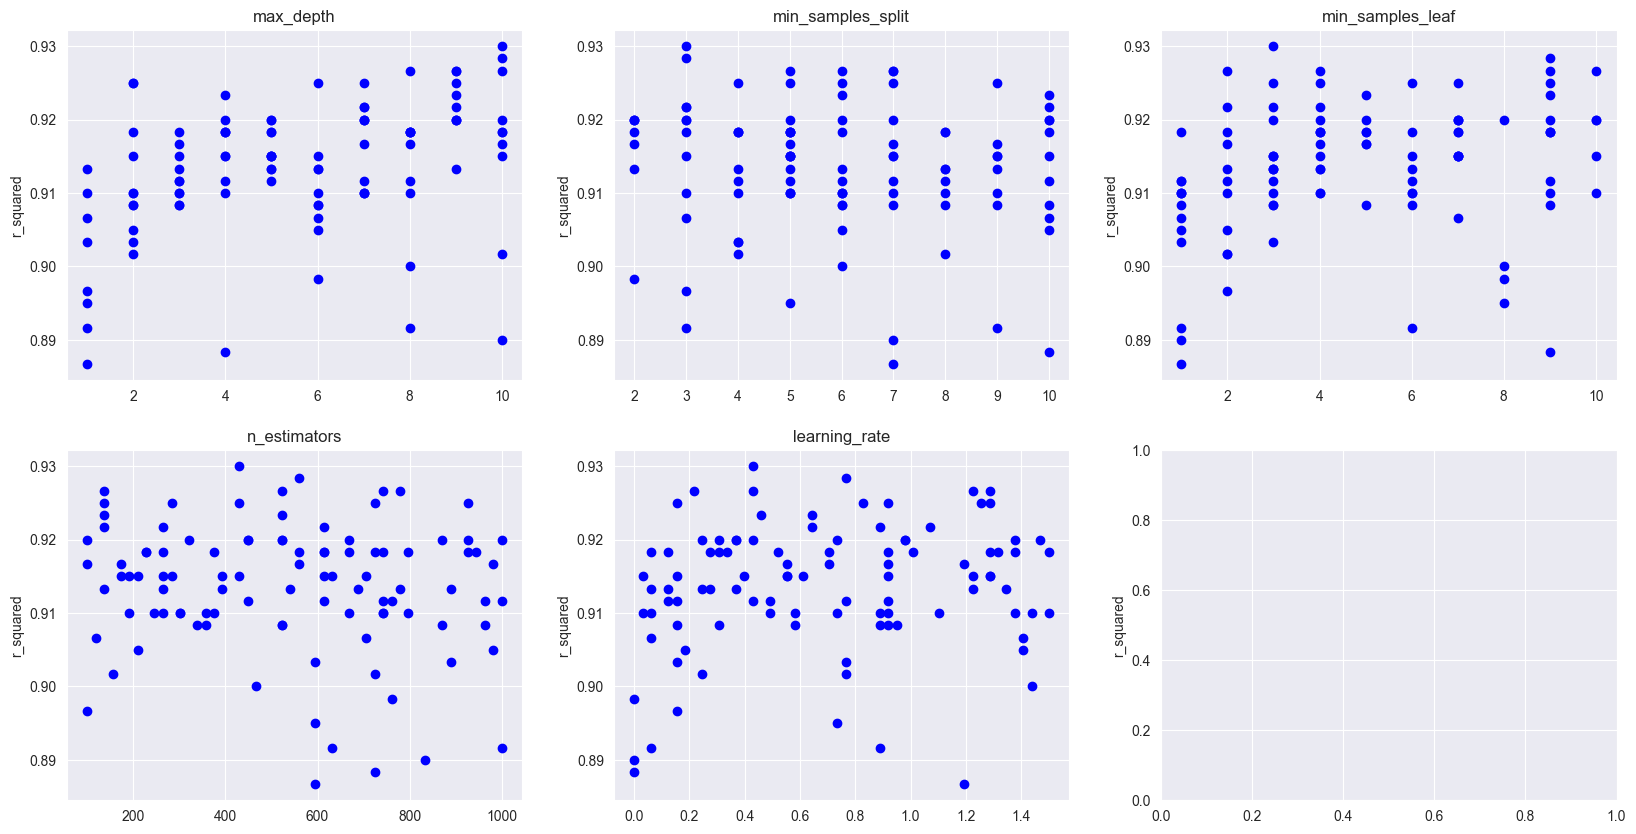

In [41]:
out2 = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_learning_rate']

fig, axs = plt.subplots(2,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue');
axs[1,1].set_title('learning_rate')

for ax in axs.flat: ax.set(ylabel='r_squared')

In [42]:
[x for x in np.linspace(start = 0.2, stop = 0.3, num = 10)]
[x for x in (np.linspace(start = 0.2, stop = 0.3, num = 10), np.linspace(start = 1.2, stop = 1.3, num = 10) )]

[array([0.2       , 0.21111111, 0.22222222, 0.23333333, 0.24444444,
        0.25555556, 0.26666667, 0.27777778, 0.28888889, 0.3       ]),
 array([1.2       , 1.21111111, 1.22222222, 1.23333333, 1.24444444,
        1.25555556, 1.26666667, 1.27777778, 1.28888889, 1.3       ])]

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

n_estimators = [797,800,803]
learning_rate = [0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,
                1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30]
max_depth = [3,7]
min_samples_split = [9,10]
min_samples_leaf = [5,9]
                                            
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gbm = GradientBoostingClassifier()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = random_grid,  cv = 3, verbose=2,  n_jobs = -1)

isotonic_gbm = CalibratedClassifierCV(gbm_grid, cv=3, method='isotonic')
isotonic_gbm.fit(X_train_smote, y_train_smote)


Fitting 3 folds for each of 528 candidates, totalling 1584 fits
Fitting 3 folds for each of 528 candidates, totalling 1584 fits
Fitting 3 folds for each of 528 candidates, totalling 1584 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=GradientBoostingClassifier(),
                                              n_jobs=-1,
                                              param_grid={'learning_rate': [0.2,
                                                                            0.21,
                                                                            0.22,
                                                                            0.23,
                                                                            0.24,
                                                                            0.25,
                                                                            0.26,
                                                                            0.27,
                                                                            0.28,
                                                                            0.29,
                                                                            0.3,
                                                                            1.2,
                                                                            1.21,
                                                                            1.22,
                                                                            1.23,
                                                                            1.24,
                                                                            1.25,
                                                                            1.26,
                                                                            1.27,
                                                                            1.28,
                                                                            1.29,
                                                                            1.3],
                                                          'max_depth': [3, 7],
                                                          'min_samples_leaf': [5,
                                                                               9],
                                                          'min_samples_split': [9,
                                                                                10],
                                                          'n_estimators': [797,
                                                                           800,
                                                                           803]},
                                              verbose=2),
                       method='isotonic')

In [44]:
y_pred_gbm = isotonic_gbm.predict(X_val_stand)
print(classification_report(y_val, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        89
           1       0.86      0.78      0.82        40

    accuracy                           0.89       129
   macro avg       0.88      0.86      0.87       129
weighted avg       0.89      0.89      0.89       129



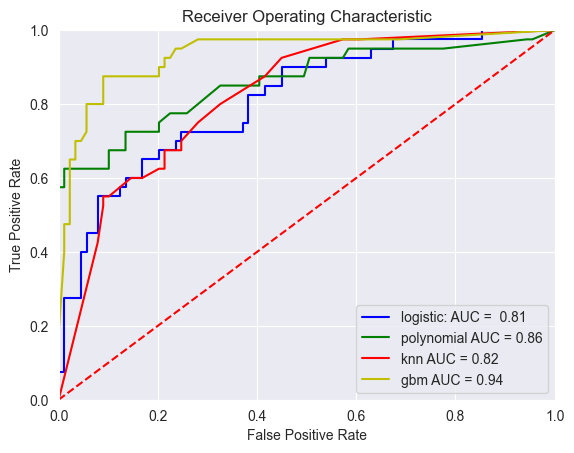

In [45]:
preds_gbm = isotonic_gbm.predict_proba(X_val_stand)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn_b)
fpr_g, tpr_g, threshold = metrics.roc_curve(y_val, preds_gbm)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)
roc_auc_g = metrics.auc(fpr_g, tpr_g)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC-curve also agrees this is the best model yet.

# 4. Support vector machines
One final model. While this model is theoretically one of the harder ones, implementing it is rather simple, just do a cross-validation using four hyperparameters.

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

C = [round(x,5) for x in np.linspace(start = 0.001, stop = 10, num = 50)]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [round(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
gamma = [round(x,5) for x in np.linspace(start = 0.001, stop = 1, num = 50)]
#gamma = ['auto', 0.3,0.5, 0.7,0.9]

random_grid = {'C': C,
               'kernel': kernel,
               'degree':degree,
               'gamma': gamma}
svc = SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter =200, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
svc_random.fit(X_train_smote, y_train_smote)

print(svc_random.best_params_)
params = svc_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'kernel': 'rbf', 'gamma': np.float64(0.12333), 'degree': 2, 'C': np.float64(7.14314)}


In [47]:
y_pred_svm = svc_random.predict(X_val_stand)
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        89
           1       0.78      0.70      0.74        40

    accuracy                           0.84       129
   macro avg       0.82      0.81      0.81       129
weighted avg       0.84      0.84      0.84       129



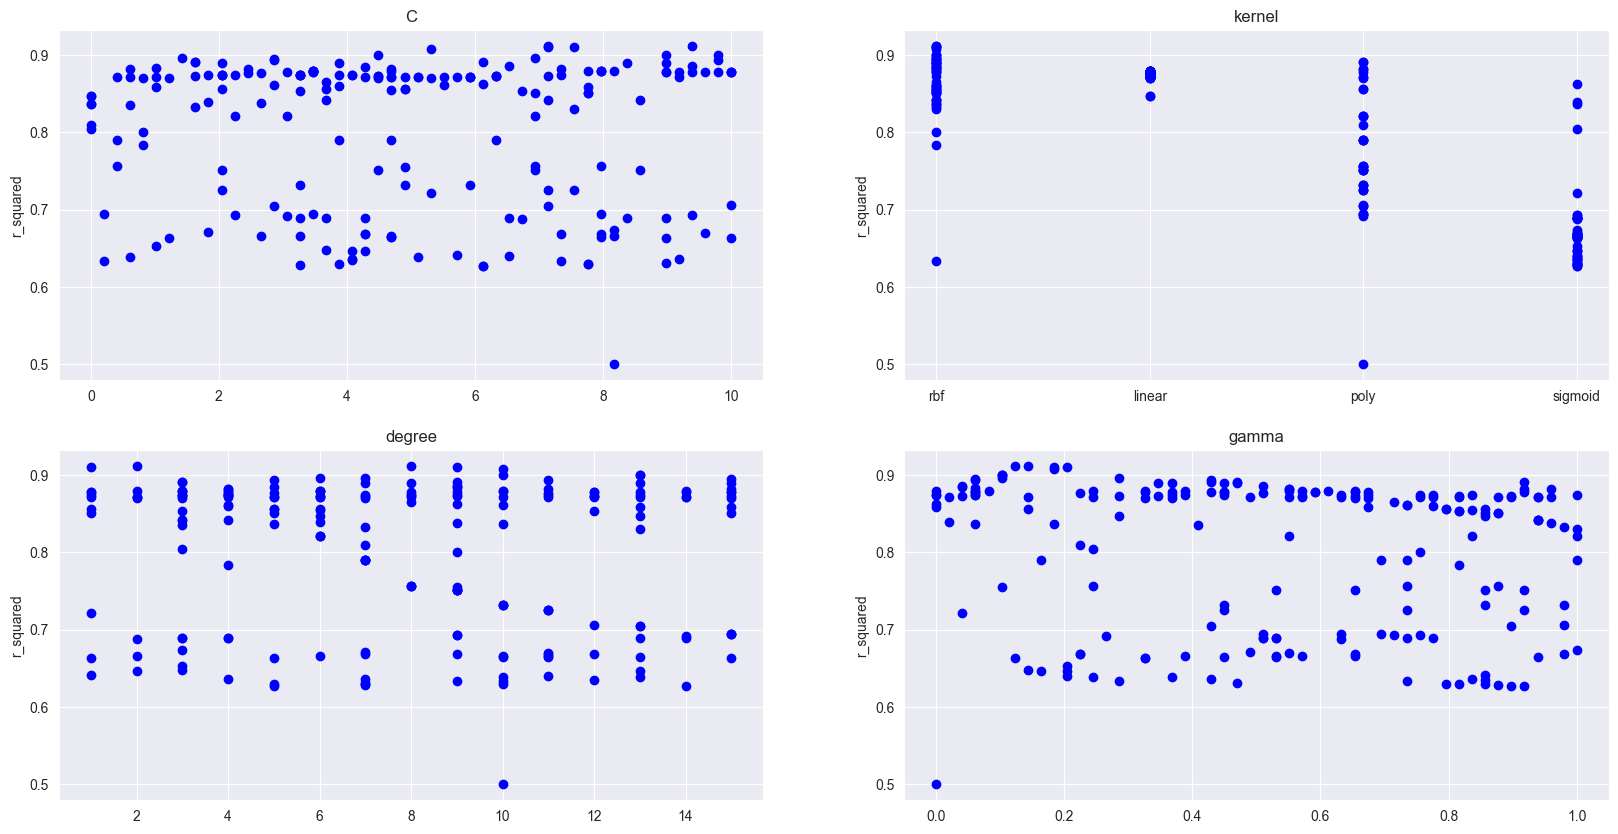

In [48]:
out2 = pd.DataFrame(svc_random.cv_results_)

xlabel_names = ['C',
               'kernel',
               'degree',
               'gamma']

fig, axs = plt.subplots(2,2, figsize=(20,10))

axs[0,0].scatter(out2['param_C'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('C')

axs[0,1].scatter(out2['param_kernel'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('kernel')

axs[1,0].scatter(out2['param_degree'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('degree')

axs[1,1].scatter(out2['param_gamma'], out2['mean_test_score'], c='blue');
axs[1,1].set_title('gamma')

for ax in axs.flat: ax.set(ylabel='r_squared')

The rbf kernel is clearly the best. This means we nog longer need the degree-parameter, since this is only used by the polynomial kernel. gamma around 0.2 perform best, and for C values between 7 and 8.

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


C = [round(x,5) for x in np.linspace(start = 7, stop = 8, num = 20)]
kernel = ['rbf']
gamma = [round(x,5) for x in np.linspace(start = 0.15, stop = 0.25, num = 20)]

random_grid = {'C': C,
               'kernel': kernel,
               'gamma': gamma}
svc = SVC()
svc_grid = GridSearchCV(estimator = svc, param_grid = random_grid,  cv = 3, verbose=2,  n_jobs = -1)

isotonic_svm = CalibratedClassifierCV(svc_grid, cv=3, method='isotonic')
isotonic_svm.fit(X_train_smote, y_train_smote)



Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Fitting 3 folds for each of 400 candidates, totalling 1200 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                                              param_grid={'C': [np.float64(7.0),
                                                                np.float64(7.05263),
                                                                np.float64(7.10526),
                                                                np.float64(7.15789),
                                                                np.float64(7.21053),
                                                                np.float64(7.26316),
                                                                np.float64(7.31579),
                                                                np.float64(7.36842),
                                                                np.float64(7.42105),
                                                                np.float64(7.47368),
                                                                np.float64(7.52632),
                                                                np.float64(7.57895),
                                                                np.float64(7.63...
                                                                    np.float64(0.17105),
                                                                    np.float64(0.17632),
                                                                    np.float64(0.18158),
                                                                    np.float64(0.18684),
                                                                    np.float64(0.19211),
                                                                    np.float64(0.19737),
                                                                    np.float64(0.20263),
                                                                    np.float64(0.20789),
                                                                    np.float64(0.21316),
                                                                    np.float64(0.21842),
                                                                    np.float64(0.22368),
                                                                    np.float64(0.22895),
                                                                    np.float64(0.23421),
                                                                    np.float64(0.23947),
                                                                    np.float64(0.24474),
                                                                    np.float64(0.25)],
                                                          'kernel': ['rbf']},
                                              verbose=2),
                       method='isotonic')

In [50]:
y_pred_svm = isotonic_svm.predict(X_val_stand)
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        89
           1       0.81      0.53      0.64        40

    accuracy                           0.81       129
   macro avg       0.81      0.73      0.76       129
weighted avg       0.81      0.81      0.80       129



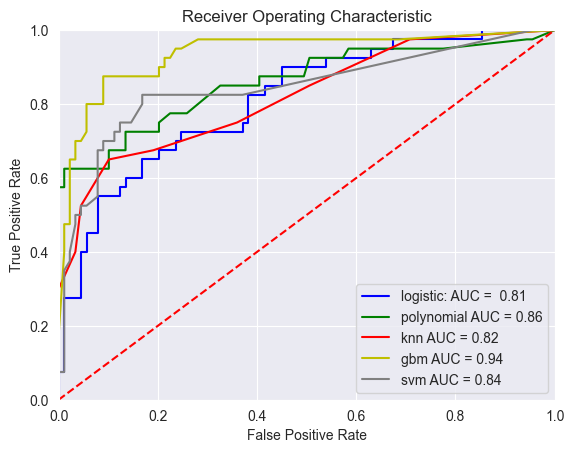

In [51]:
preds_svm = isotonic_svm.predict_proba(X_val_stand)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_k, tpr_k, threshold = metrics.roc_curve(y_val, preds_knn)
fpr_g, tpr_g, threshold = metrics.roc_curve(y_val, preds_gbm)
fpr_s, tpr_s, threshold = metrics.roc_curve(y_val, preds_svm)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_k = metrics.auc(fpr_k, tpr_k)
roc_auc_g = metrics.auc(fpr_g, tpr_g)
roc_auc_s = metrics.auc(fpr_s, tpr_s)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_k, tpr_k, 'r', label = 'knn AUC = %0.2f' % roc_auc_k)
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)
plt.plot(fpr_s, tpr_s, 'grey', label = 'svm AUC = %0.2f' % roc_auc_s)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()